In [1]:
import sys, os
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')

from adinilm.objs import ProfileHandler, DatasetProfile
from adinilm.utils import paths_manager as pathsman

In [2]:
profile_path = None

In [3]:
if profile_path:
        profile = DatasetProfile.extract(profile_path=profile_path)
else:
        available_profiles = sorted(list(os.listdir(pathsman.PROFILES_DIR)))
        recent_profile = available_profiles[-1]
        profile = DatasetProfile.extract(pathsman.PROFILES_DIR / recent_profile)

In [4]:
def get_mae(target, prediction):
    return mean_absolute_error(target, prediction)

def get_eac(target, prediction):
    num = np.sum(np.abs(prediction-target))
    den = (np.sum(target))
    eac = 1 - (num/den)/2
    return np.where(eac<0, 0, eac)

def get_relative_error(target, prediction):
    return np.mean(np.nan_to_num(np.abs(target - prediction) / np.maximum(target, prediction)))

def get_nde(target, prediction):
    return np.sum((target - prediction) ** 2) / np.sum((target ** 2))

def compute_regress_metrics(target, prediction):
    eac = get_eac(target, prediction)
    mae = get_mae(target, prediction)
    nade = get_nde(target, prediction)
    
    metrics = OrderedDict([('EAC', eac),
                        ('MAE', mae),
                        ('NDE', nade)])
    
    metrics_dict = {}
    metrics_dict['EAC'] = metrics["EAC"]
    metrics_dict['MAE'] = metrics["MAE"]
    metrics_dict['NDE'] = metrics["NDE"]
    
    return metrics_dict


In [5]:
appliance_data = profile.metadata
appliances= list(appliance_data.keys())

In [6]:
result_unet = np.load("../logs/ukdale-train___2024.03.19-030238/results.npy", allow_pickle=True).item()

In [7]:
pred_power=result_unet['pred_power']
pred_state=result_unet['pred_state']
power=result_unet['power']
state=result_unet['state']

In [8]:
def smape_score(target, prediction):
    denom = np.abs(prediction) + np.abs(target) 
    score =(2 * np.abs(prediction - target).mean(0))/(denom.mean(0) + 1e-8)
    return score  

In [9]:
y_t = power 
y_p =  pred_power[:,2,:]
def get_CEP(y_t, y_p):
    c = np.sum((y_t == y_p).astype(int)*y_p, 0)
    ce = np.sum((y_t > y_p).astype(int)*y_t, 0)
    co = np.sum((y_t < y_p).astype(int)*y_p, 0)
    gt = np.sum(y_t, 0)
    CEP = (c + ce + co)[gt!=0]/(gt[gt!=0])
    CEP[gt==0]=1.0
    return CEP
gt = np.sum(y_t, 0)
O = np.sum( (y_p - y_t), 0)
U = np.sum( (y_t - y_p), 0)

OE = O[gt!=0]/(gt[gt!=0])
OE

array([1.26134281e+03, 4.10251576e-02, 1.85876394e+03, 1.02126840e-01,
       1.84979698e+03])

In [10]:
smape_score(power, pred_power[:,2,:])

array([32621422.66019956,  3947053.90054944,  4144403.49910084,
        2770774.06010063,  6372651.78034532])

In [11]:
pred_power=result_unet['pred_power']
pred_state=result_unet['pred_state']
power=result_unet['power']
state=result_unet['state']
all_reg_results_mean = []
all_reg_results_std = []
regress = {}
for idx, app in enumerate(list(appliance_data.keys())):
    regress_results = []
    for  q in range(5):
        result = compute_regress_metrics(power[:,idx]*state[:,idx], pred_power[:,q,idx]*pred_state[:,idx])
        result = pd.DataFrame.from_dict(result, orient="index")
        regress_results.append(result)
    regress_results = pd.concat(regress_results, axis=1)
    #regress_results.columns = list(appliance_data.keys())
    #regress[app]=regress_results
    print("APP", app)
    mean = regress_results.mean(1).round(3)
    std  = regress_results.std(1).round(3)
    reg=pd.concat([mean, std], axis=1)
    reg.columns =["mean", 'std']
    all_reg_results_mean.append( mean)
    all_reg_results_std.append(std)
    print(reg)
    print("")
#ebf1 = {"ExbF1":example_f1_score(state, pred_state, axis=0, per_sample=True).tolist()}
#ebf1 =pd.DataFrame.from_dict(ebf1, orient="index")
#ebf1.columns = list(appliance_data.keys())
print("")
#print(ebf1.round(3))

#print(pd.DataFrame.from_dict(compute_metrics(state, pred_state), orient="index"))

APP fridge freezer
       mean     std
EAC   0.535   0.322
MAE  44.017  30.454
NDE   1.173   1.314

APP washer dryer
        mean      std
EAC    0.566    0.348
MAE  273.786  268.667
NDE    1.035    1.352

APP kettle
       mean  std
EAC   0.500  0.0
MAE  32.073  0.0
NDE   1.000  0.0

APP dish washer
        mean      std
EAC    0.612    0.380
MAE  308.332  313.287
NDE    0.752    0.939

APP microwave
       mean     std
EAC   0.625   0.170
MAE  24.133  10.936
NDE   0.727   0.370




## Visual

In [12]:
start = 24400

In [13]:
y_p_unet = result_unet['pred_power'][start:start+200]
y_t_unet = result_unet['power'][start:start+200]
z_t_unet = result_unet['state'][start:start+200]
z_p_unet = result_unet['pred_state'][start:start+200]

In [14]:
colors =[plt.cm.Blues(0.6), plt.cm.Reds(0.4), plt.cm.Greens(0.6), '#ffcc99', plt.cm.Greys(0.6)]

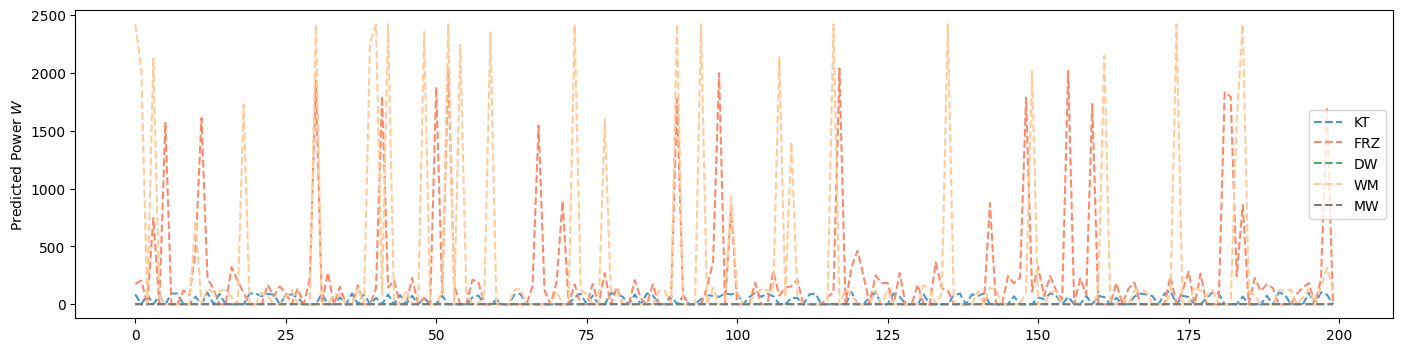

In [15]:
appliance_labels={'kettle':"KT", 'fridge':"FRZ", 'dishwasher':"DW", 'washingmachine':"WM", 'microwave':"MW"}
fig = plt.figure(figsize=(17, 4))
for i, app in enumerate(list(appliance_labels)):
    #plt.plot(y_t_cnn[:,i], label=appliance_labels[app], color=colors[i])
    plt.plot(y_p_unet[:,2,i]*z_p_unet[:,i], label=appliance_labels[app], color=colors[i], linestyle="--")
plt.ylabel("Predicted Power $W$")
plt.legend()
# plt.savefig("unet_prediction", format="pdf")

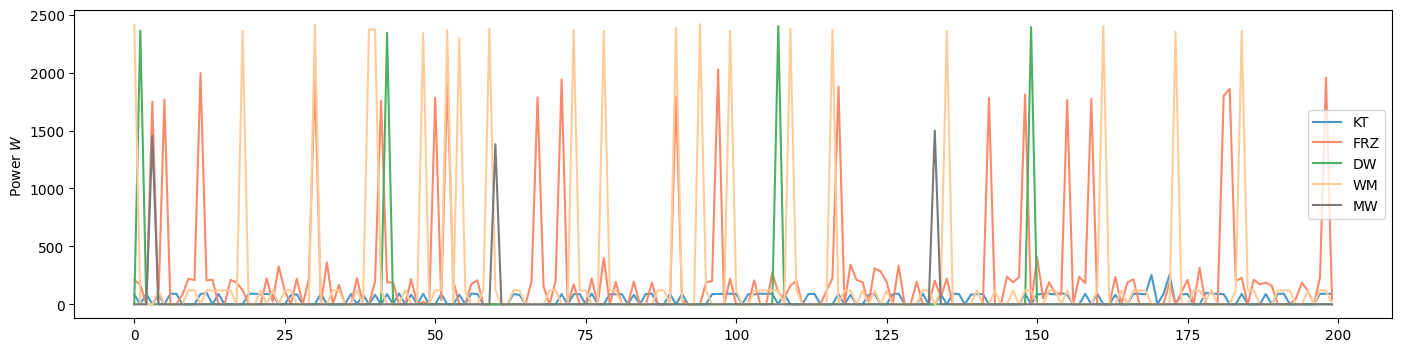

In [16]:
appliance_labels={'kettle':"KT", 'fridge':"FRZ", 'dishwasher':"DW", 'washingmachine':"WM", 'microwave':"MW"}
fig = plt.figure(figsize=(17, 4))
for i, app in enumerate(list(appliance_labels.keys())):
    plt.plot(y_t_unet[:,i]*z_t_unet[:,i], label=appliance_labels[app], color=colors[i])
    #plt.plot(y_p_unet[:,2,i]t label=appliance_labels[app], color=colors[i], linestyle="--")
plt.ylabel("Power $W$")
plt.legend()

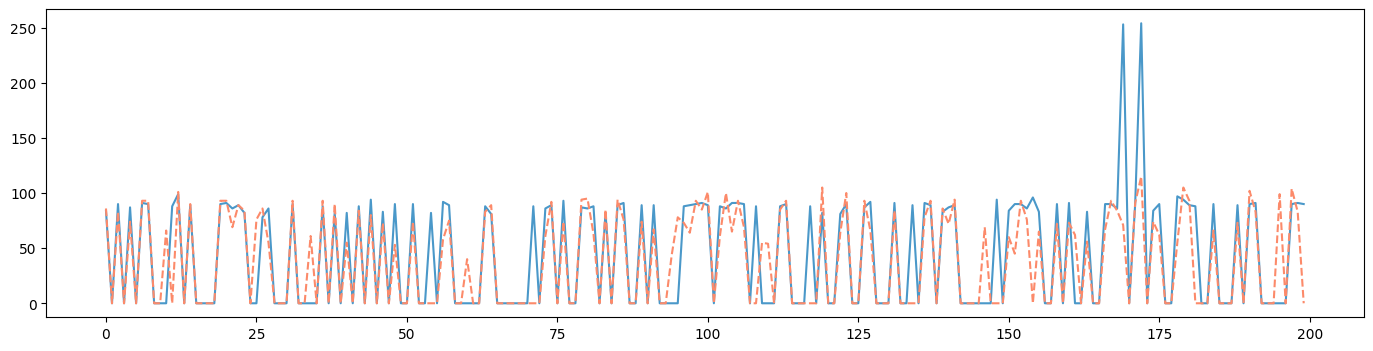

In [17]:
app = 'kettle'
i = 0
fig = plt.figure(figsize=(17, 4))
plt.plot(y_t_unet[:,i]*z_t_unet[:,i], label=appliance_labels[app], color=colors[i])
plt.plot(y_p_unet[:,2,i]*z_p_unet[:,i], label=appliance_labels[app], color=colors[i+1], linestyle="--")
# plt.plot(y_t_unet[:,i], label=appliance_labels[app], color=colors[i])
# plt.plot(y_p_unet[:,2,i], label=appliance_labels[app], color=colors[i+1], linestyle="--")
# plt.plot(z_t_unet[:,i], label=appliance_labels[app], color=colors[i])
# plt.plot(z_p_unet[:,i], label=appliance_labels[app], color=colors[i+1], linestyle="--")

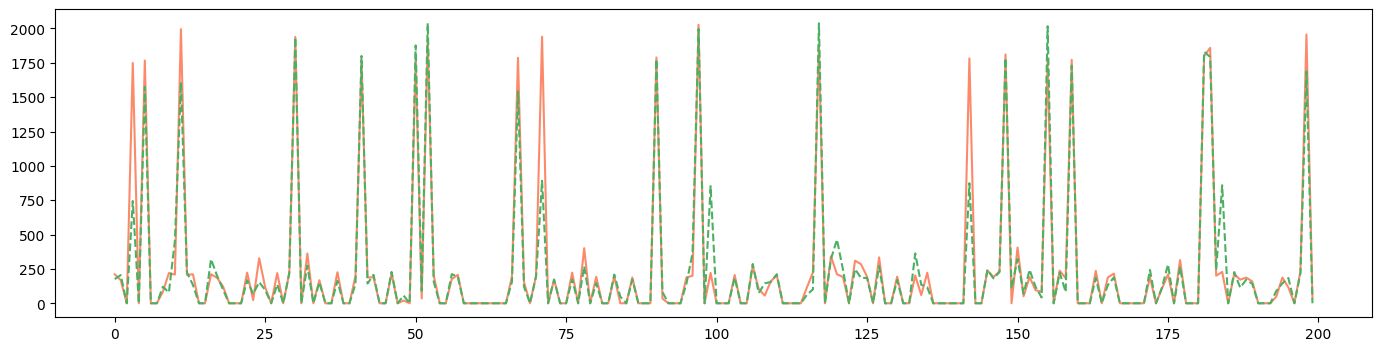

In [18]:
app = 'fridge'
i = 1
fig = plt.figure(figsize=(17, 4))
plt.plot(y_t_unet[:,i]*z_t_unet[:,i], label=appliance_labels[app], color=colors[i])
plt.plot(y_p_unet[:,2,i]*z_p_unet[:,i], label=appliance_labels[app], color=colors[i+1], linestyle="--")

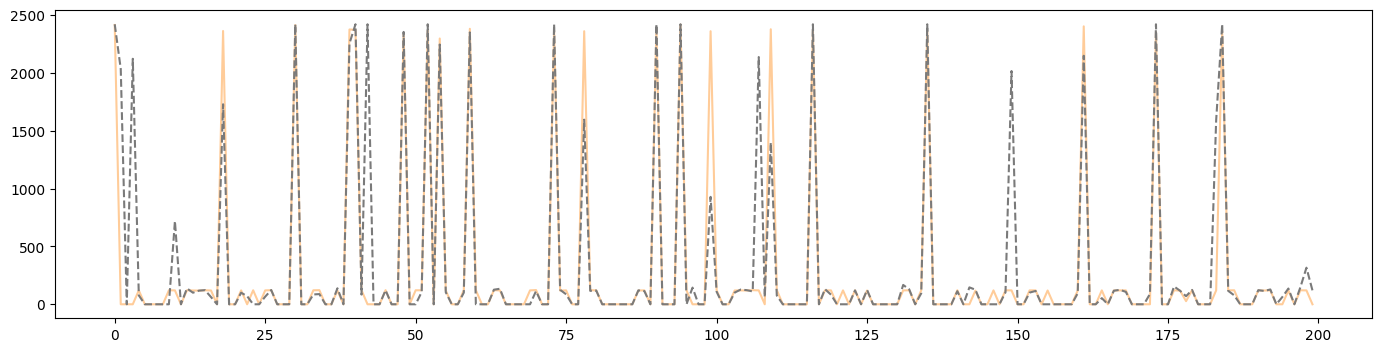

In [19]:
app = 'washingmachine'
i = 3
fig = plt.figure(figsize=(17, 4))
plt.plot(y_t_unet[:,i]*z_t_unet[:,i], label=appliance_labels[app], color=colors[i])
plt.plot(y_p_unet[:,2,i]*z_p_unet[:,i], label=appliance_labels[app], color=colors[i+1], linestyle="--")
# plt.plot(y_t_unet[:,i], label=appliance_labels[app], color=colors[i])
# plt.plot(y_p_unet[:,2,i], label=appliance_labels[app], color=colors[i+1], linestyle="--")

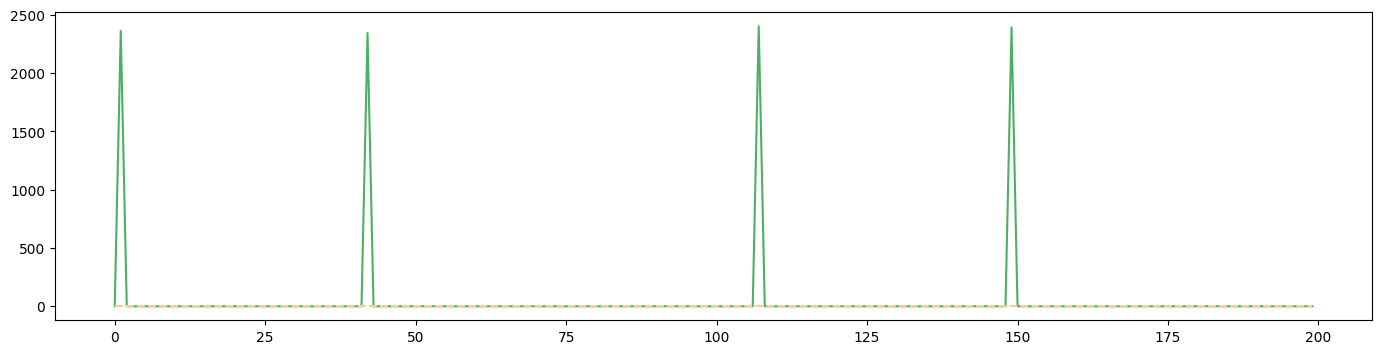

In [20]:
app = 'dishwasher'
i = 2
fig = plt.figure(figsize=(17, 4))
plt.plot(y_t_unet[:,i]*z_t_unet[:,i], label=appliance_labels[app], color=colors[i])
plt.plot(y_p_unet[:,2,i]*z_p_unet[:,i], label=appliance_labels[app], color=colors[i+1], linestyle="--")

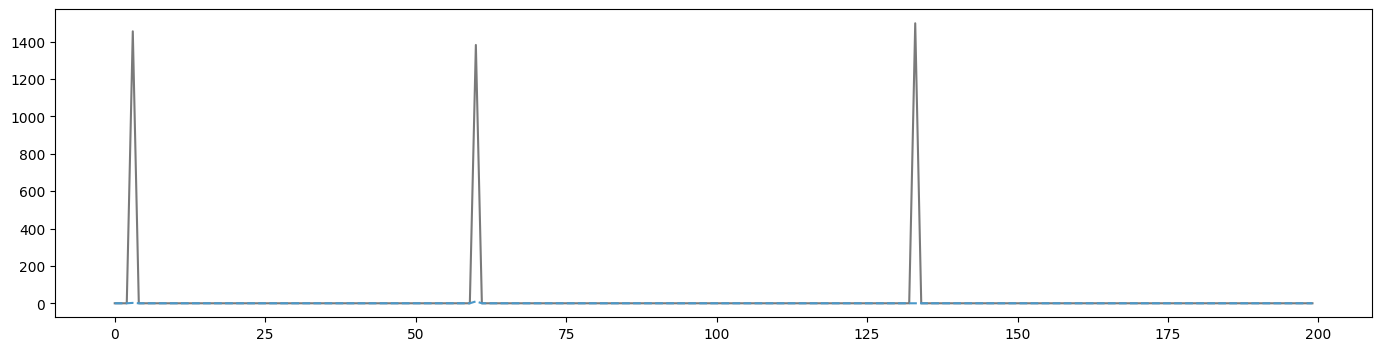

In [21]:
app = 'microwave'
i = 4
fig = plt.figure(figsize=(17, 4))
plt.plot(y_t_unet[:,i]*z_t_unet[:,i], label=appliance_labels[app], color=colors[i])
plt.plot(y_p_unet[:,2,i]*z_p_unet[:,i], label=appliance_labels[app], color=colors[0], linestyle="--")